In [121]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score


In [122]:
# 读取数据
df = pd.read_excel(r"F:\codes\00-WORK\work-1\01-myself\01-predict\03-classification\EXCEL\CS-TC.xlsx",  dtype={'DIPOCE': str, 'BA_Code': str, 'Cata_Code': str, 'FM_N': str})
df

,DIPOCE,DI_NCO,PO_HV,PO_f,BA_Code,BA_Mn,PO_Phr,BA_Phr,FS_Phr,Cata_Phr,...,Yield,R,CHS,Q,Cata_Code,MCS,Closed_CC,TC,CS,AD
0,0110100000,31.0,367.991736,4.464132,1000,18.0,67.567568,2.182432,1.013514,1.013514,...,96.884711,1.83,59.700000,0.0,100000,108.6,90.8,24.36,212.6,36.8
1,0110000000,31.0,420.000000,4.500000,1000,18.0,59.000000,2.000000,0.880000,0.900000,...,97.005005,1.70,62.900000,0.0,100000,123.3,92.3,24.55,221.7,39.8
2,0110000000,31.0,420.000000,4.500000,1000,18.0,59.000000,2.000000,0.880000,0.900000,...,97.005005,1.70,62.900000,0.0,100000,123.3,92.3,24.55,174.8,38.3
3,0110100000,31.0,367.991736,4.464132,1000,18.0,67.567568,2.182432,1.013514,1.013514,...,96.884711,1.83,59.700000,0.0,100000,128.1,93.1,25.35,210.3,41.2
4,0110100000,31.0,367.991736,4.464132,1000,18.0,67.567568,2.182432,1.013514,1.013514,...,96.884711,1.83,59.700000,0.0,100000,128.1,93.1,25.35,143.8,35.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,0110000010,31.0,450.000000,3.000000,1000,18.0,55.555556,0.333333,1.166667,0.222222,...,99.492678,1.05,64.285714,48.0,100000,155.0,96.1,46.20,1670.0,37.8
164,0110000010,31.0,450.000000,3.000000,1000,18.0,54.644809,0.437158,1.147541,0.218579,...,99.330977,1.05,64.664311,48.0,100000,180.0,95.1,42.50,1330.0,58.0
165,0110000010,31.0,450.000000,3.000000,1000,18.0,53.475936,0.534759,1.122995,0.213904,...,99.175567,1.05,65.156794,48.0,100000,206.0,94.0,41.10,1090.0,81.3
166,0110000010,31.0,450.000000,3.000000,1000,18.0,52.631579,0.631579,1.105263,0.210526,...,99.021243,1.05,65.517241,48.0,100000,253.0,93.1,40.90,740.0,97.6


In [123]:
import pandas as pd

# 假设 df 已读取，并包含 'AD', 'CS', 'TC'
# 计算 50% 分位数
CS_50 = df['CS'].quantile(0.5)
TC_50 = df['TC'].quantile(0.5)
AD_50 = df['AD'].quantile(0.5)

print(f"CS_50: {CS_50}, TC_50: {TC_50}, AD_50: {AD_50}")

# 分象限，用 CS 和 TC 划分
def get_quadrant(row):
    cs = "+" if row["CS"] > CS_50 else "-"
    tc = "+" if row["TC"] > TC_50 else "-"
    return f"{cs}{tc}"  # CS先，TC后

df["Quadrant"] = df.apply(get_quadrant, axis=1)

# 1. 每个象限的数量和比例
quadrant_stats = df["Quadrant"].value_counts().reset_index()
quadrant_stats.columns = ["Quadrant", "Count"]
quadrant_stats["Percent"] = (quadrant_stats["Count"] / len(df) * 100).round(2)

# 2. 每个象限内 AD、CS、TC 的 min/max/mean
quadrant_ranges = (
    df.groupby("Quadrant")[["AD", "CS", "TC"]]
      .agg(['min', 'max', 'mean'])
      .round(2)
)

# 3. 扁平化多级列索引
quadrant_ranges.columns = [f"{feat}_{agg}" for feat, agg in quadrant_ranges.columns]

# 4. 合并统计表
summary = quadrant_stats.merge(quadrant_ranges, on="Quadrant", how="left")
summary

CS_50: 183.0, TC_50: 25.58, AD_50: 41.849999999999994


,Quadrant,Count,Percent,AD_min,AD_max,AD_mean,CS_min,CS_max,CS_mean,TC_min,TC_max,TC_mean
0,--,49,29.17,31.20,122.0,53.27,103.0,181.0,153.18,15.1,25.58,22.48
1,++,48,28.57,27.41,122.5,53.85,190.0,2890.0,582.03,25.9,46.20,36.69
2,+-,36,21.43,26.40,148.0,43.88,185.0,723.0,290.23,20.0,25.58,23.24
3,-+,35,20.83,25.10,105.0,44.75,49.1,180.0,129.96,25.6,51.00,34.59


In [100]:
# 创建 classification 列，++象限为 1，其余为0+- 
df["classification"] = df["Quadrant"].apply(lambda x: 1 if x == "-+" else 0)
df 

,DIPOCE,DI_NCO,PO_HV,PO_f,BA_Code,BA_Mn,PO_Phr,BA_Phr,FS_Phr,Cata_Phr,...,R,CHS,Q,Cata_Code,MCS,Closed_CC,TC,CS,Quadrant,classification
0,0110100000,31.0,367.991736,4.464132,1000,18.0,67.567568,2.182432,1.013514,1.013514,...,1.83,59.700000,0.0,100000,108.6,90.8,24.36,212.6,+-,0
1,0110000000,31.0,420.000000,4.500000,1000,18.0,59.000000,2.000000,0.880000,0.900000,...,1.70,62.900000,0.0,100000,123.3,92.3,24.55,221.7,+-,0
2,0110000000,31.0,420.000000,4.500000,1000,18.0,59.000000,2.000000,0.880000,0.900000,...,1.70,62.900000,0.0,100000,123.3,92.3,24.55,174.8,--,0
3,0110100000,31.0,367.991736,4.464132,1000,18.0,67.567568,2.182432,1.013514,1.013514,...,1.83,59.700000,0.0,100000,128.1,93.1,25.35,210.3,+-,0
4,0110100000,31.0,367.991736,4.464132,1000,18.0,67.567568,2.182432,1.013514,1.013514,...,1.83,59.700000,0.0,100000,128.1,93.1,25.35,143.8,--,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,0110000010,31.0,450.000000,3.000000,1000,18.0,55.555556,0.333333,1.166667,0.222222,...,1.05,64.285714,48.0,100000,155.0,96.1,46.20,1670.0,++,0
164,0110000010,31.0,450.000000,3.000000,1000,18.0,54.644809,0.437158,1.147541,0.218579,...,1.05,64.664311,48.0,100000,180.0,95.1,42.50,1330.0,++,0
165,0110000010,31.0,450.000000,3.000000,1000,18.0,53.475936,0.534759,1.122995,0.213904,...,1.05,65.156794,48.0,100000,206.0,94.0,41.10,1090.0,++,0
166,0110000010,31.0,450.000000,3.000000,1000,18.0,52.631579,0.631579,1.105263,0.210526,...,1.05,65.517241,48.0,100000,253.0,93.1,40.90,740.0,++,0


In [101]:
# 删除原始列
df.drop(columns=[ "CS", "TC", 'Quadrant'], inplace=True)

# df.to_excel("processed_classification.xlsx", index=False)
df

,DIPOCE,DI_NCO,PO_HV,PO_f,BA_Code,BA_Mn,PO_Phr,BA_Phr,FS_Phr,Cata_Phr,C_BA_MR,M_loss,Yield,R,CHS,Q,Cata_Code,MCS,Closed_CC,classification
0,0110100000,31.0,367.991736,4.464132,1000,18.0,67.567568,2.182432,1.013514,1.013514,0.180000,5.351351,96.884711,1.83,59.700000,0.0,100000,108.6,90.8,0
1,0110000000,31.0,420.000000,4.500000,1000,18.0,59.000000,2.000000,0.880000,0.900000,0.189000,4.900419,97.005005,1.70,62.900000,0.0,100000,123.3,92.3,0
2,0110000000,31.0,420.000000,4.500000,1000,18.0,59.000000,2.000000,0.880000,0.900000,0.189000,4.900419,97.005005,1.70,62.900000,0.0,100000,123.3,92.3,0
3,0110100000,31.0,367.991736,4.464132,1000,18.0,67.567568,2.182432,1.013514,1.013514,0.180000,5.351351,96.884711,1.83,59.700000,0.0,100000,128.1,93.1,0
4,0110100000,31.0,367.991736,4.464132,1000,18.0,67.567568,2.182432,1.013514,1.013514,0.180000,5.351351,96.884711,1.83,59.700000,0.0,100000,128.1,93.1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,0110000010,31.0,450.000000,3.000000,1000,18.0,55.555556,0.333333,1.166667,0.222222,0.033333,0.814815,99.492678,1.05,64.285714,48.0,100000,155.0,96.1,0
164,0110000010,31.0,450.000000,3.000000,1000,18.0,54.644809,0.437158,1.147541,0.218579,0.044444,1.068610,99.330977,1.05,64.664311,48.0,100000,180.0,95.1,0
165,0110000010,31.0,450.000000,3.000000,1000,18.0,53.475936,0.534759,1.122995,0.213904,0.055556,1.307190,99.175567,1.05,65.156794,48.0,100000,206.0,94.0,0
166,0110000010,31.0,450.000000,3.000000,1000,18.0,52.631579,0.631579,1.105263,0.210526,0.066667,1.543860,99.021243,1.05,65.517241,48.0,100000,253.0,93.1,0


In [102]:
missing_rate = df.isnull().sum() / len(df)
# print(missing_rate)
# 找出缺失值比例大于 0.5 的列
cols_to_drop = missing_rate[missing_rate > 0.5].index
#打印缺失值比例大于 0.5 的列的缺失率
print("缺失值比例大于 0.5 的列：")
print(missing_rate[missing_rate > 0.5])

缺失值比例大于 0.5 的列：
Series([], dtype: float64)


In [103]:
# # 删除缺失值比例大于 0.5 的列
# df.drop(columns=cols_to_drop, inplace=True)
# df.shape

In [104]:
import numpy as np
import pandas as pd
from matimpute import MatImputer

mat_impute = MatImputer()
df = mat_impute.transform(df)
df.to_excel(r"F:\codes\00-WORK\work-1\01-myself\01-predict\03-classification\EXCEL\-+_MatImputer.xlsx", index=False)

In [105]:
X = df.drop(columns=['classification'])
y = df['classification']
X

,DIPOCE,DI_NCO,PO_HV,PO_f,BA_Code,BA_Mn,PO_Phr,BA_Phr,FS_Phr,Cata_Phr,C_BA_MR,M_loss,Yield,R,CHS,Q,Cata_Code,MCS,Closed_CC
0,0110100000,31.0,367.991736,4.464132,1000,18.0,67.567568,2.182432,1.013514,1.013514,0.180000,5.351351,96.884711,1.83,59.700000,0.0,100000,108.6,90.8
1,0110000000,31.0,420.000000,4.500000,1000,18.0,59.000000,2.000000,0.880000,0.900000,0.189000,4.900419,97.005005,1.70,62.900000,0.0,100000,123.3,92.3
2,0110000000,31.0,420.000000,4.500000,1000,18.0,59.000000,2.000000,0.880000,0.900000,0.189000,4.900419,97.005005,1.70,62.900000,0.0,100000,123.3,92.3
3,0110100000,31.0,367.991736,4.464132,1000,18.0,67.567568,2.182432,1.013514,1.013514,0.180000,5.351351,96.884711,1.83,59.700000,0.0,100000,128.1,93.1
4,0110100000,31.0,367.991736,4.464132,1000,18.0,67.567568,2.182432,1.013514,1.013514,0.180000,5.351351,96.884711,1.83,59.700000,0.0,100000,128.1,93.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,0110000010,31.0,450.000000,3.000000,1000,18.0,55.555556,0.333333,1.166667,0.222222,0.033333,0.814815,99.492678,1.05,64.285714,48.0,100000,155.0,96.1
164,0110000010,31.0,450.000000,3.000000,1000,18.0,54.644809,0.437158,1.147541,0.218579,0.044444,1.068610,99.330977,1.05,64.664311,48.0,100000,180.0,95.1
165,0110000010,31.0,450.000000,3.000000,1000,18.0,53.475936,0.534759,1.122995,0.213904,0.055556,1.307190,99.175567,1.05,65.156794,48.0,100000,206.0,94.0
166,0110000010,31.0,450.000000,3.000000,1000,18.0,52.631579,0.631579,1.105263,0.210526,0.066667,1.543860,99.021243,1.05,65.517241,48.0,100000,253.0,93.1


In [106]:
# 划分数据集（假设 X 和 y 已定义）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [107]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

classification
0    0.791045
1    0.208955
Name: proportion, dtype: float64
classification
0    0.794118
1    0.205882
Name: proportion, dtype: float64


In [ ]:
import optuna
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score

# 使用 StratifiedKFold 保持类别比例
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Optuna 目标函数（优化 f1-score，更适合不平衡数据）
def objective(trial):
    param_grid = {
        'iterations': trial.suggest_int('iterations', 500, 1000, step=100),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 128)
    }

    model = CatBoostClassifier(
        **param_grid,
        random_state=42,
        auto_class_weights='Balanced',  # 自动处理类别不平衡
        verbose=0 
    )

    pipeline = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])

    score = cross_val_score(pipeline, X_train, y_train,
                            cv=cv, scoring=make_scorer(f1_score), n_jobs=-1)
    
    return score.mean()

# 创建 study 对象
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# 输出结果
print("✅ 最佳超参数组合：")
print(study.best_params)
print(f"最佳平均 F1 分数：{study.best_value:.4f}")


[I 2025-07-15 09:59:54,223] A new study created in memory with name: no-name-0e6f8a0f-68a4-4f80-9e60-20e131105321
[I 2025-07-15 09:59:55,257] Trial 0 finished with value: 0.8078431372549021 and parameters: {'iterations': 800, 'depth': 5, 'learning_rate': 0.10162420651626082, 'l2_leaf_reg': 3, 'border_count': 49}. Best is trial 0 with value: 0.8078431372549021.
[I 2025-07-15 09:59:56,372] Trial 1 finished with value: 0.7598039215686274 and parameters: {'iterations': 600, 'depth': 6, 'learning_rate': 0.1790318972928934, 'l2_leaf_reg': 4, 'border_count': 126}. Best is trial 0 with value: 0.8078431372549021.
[I 2025-07-15 09:59:57,287] Trial 2 finished with value: 0.794973544973545 and parameters: {'iterations': 900, 'depth': 3, 'learning_rate': 0.06659301025768516, 'l2_leaf_reg': 3, 'border_count': 65}. Best is trial 0 with value: 0.8078431372549021.
[I 2025-07-15 09:59:58,555] Trial 3 finished with value: 0.7598039215686274 and parameters: {'iterations': 800, 'depth': 6, 'learning_rate':

✅ 最佳超参数组合：
{'iterations': 900, 'depth': 3, 'learning_rate': 0.017336950274420934, 'l2_leaf_reg': 1, 'border_count': 120}
最佳平均 F1 分数：0.8496


In [109]:
Best_hyperparameters = study.best_params
Best_hyperparameters

{'iterations': 900,
 'depth': 3,
 'learning_rate': 0.017336950274420934,
 'l2_leaf_reg': 1,
 'border_count': 120}

In [110]:
import json

# 假设 study 是你调参后的 Optuna study 对象
with open('-+_best_params.json', 'w') as f:
    json.dump(study.best_params, f)

In [111]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 使用最优超参数训练分类模型
best_model = CatBoostClassifier(**Best_hyperparameters, random_state=42, verbose=0)

# 在训练集上训练模型
best_model.fit(X_train, y_train)

# 在测试集和训练集上进行预测
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# 计算分类模型的指标
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

precision_train = precision_score(y_train, y_pred_train, average='weighted')
precision_test = precision_score(y_test, y_pred_test, average='weighted')

recall_train = recall_score(y_train, y_pred_train, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')

f1_train = f1_score(y_train, y_pred_train, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')

# 输出结果
print(f"accuracy_train: {accuracy_train:.4f}")
print(f"accuracy_test: {accuracy_test:.4f}")

print(f"precision_train: {precision_train:.4f}")
print(f"precision_test: {precision_test:.4f}")

print(f"recall_train: {recall_train:.4f}")
print(f"recall_test: {recall_test:.4f}")

print(f"f1_train: {f1_train:.4f}")
print(f"f1_test: {f1_test:.4f}")


accuracy_train: 0.9851
accuracy_test: 0.9118
precision_train: 0.9854
precision_test: 0.9090
recall_train: 0.9851
recall_test: 0.9118
f1_train: 0.9849
f1_test: 0.9092


In [112]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from catboost import CatBoostClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 定义评估函数
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1

# 将每一折的训练集和验证集的评估指标分别存储
train_accuracy_scores = []
val_accuracy_scores = []
train_precision_scores = []
val_precision_scores = []
train_recall_scores = []
val_recall_scores = []
train_f1_scores = []
val_f1_scores = []
# 存储结果的容器
results = []
# ROC 曲线相关初始化
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)  # 统一横坐标
cv = KFold(n_splits=3, shuffle=True, random_state=42)
# 🔹 添加：用于汇总所有验证集预测结果
all_y_val = []
all_y_pred_val = []

# 交叉验证
for fold, (train_index, val_index) in enumerate(cv.split(X), start=1):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    best_model.fit(X_train_resampled, y_train_resampled)

    y_pred_train = best_model.predict(X_train_resampled)
    y_pred_val = best_model.predict(X_val)

    # 🔹 添加：保存验证集真实标签与预测标签
    all_y_val.extend(y_val)
    all_y_pred_val.extend(y_pred_val)

    accuracy_train, precision_train, recall_train, f1_train = evaluate_model(y_train_resampled, y_pred_train)
    accuracy_val, precision_val, recall_val, f1_val = evaluate_model(y_val, y_pred_val)

    train_accuracy_scores.append(accuracy_train)
    val_accuracy_scores.append(accuracy_val)
    train_precision_scores.append(precision_train)
    val_precision_scores.append(precision_val)
    train_recall_scores.append(recall_train)
    val_recall_scores.append(recall_val)
    train_f1_scores.append(f1_train)
    val_f1_scores.append(f1_val)

    y_prob = best_model.predict_proba(X_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)

    results.append({'fold': fold, 'fpr': fpr, 'tpr': tpr, 'auc': roc_auc})

# 🔹 原表格输出保持不变
df_results = pd.DataFrame({
    'Fold': range(1, 4),
    'accuracy_train': train_accuracy_scores,
    'accuracy_val': val_accuracy_scores,
    'precision_train': train_precision_scores,
    'precision_val': val_precision_scores,
    'recall_train': train_recall_scores,
    'recall_val': val_recall_scores,
    'f1_train': train_f1_scores,
    'f1_val': val_f1_scores
})

In [113]:
print("原始类别分布：")
print(y_train.value_counts())

print("过采样后的类别分布：")
print(pd.Series(y_train_resampled).value_counts())

原始类别分布：
classification
0    86
1    26
Name: count, dtype: int64
过采样后的类别分布：
classification
0    86
1    86
Name: count, dtype: int64


In [114]:
df_results

,Fold,accuracy_train,accuracy_val,precision_train,precision_val,recall_train,recall_val,f1_train,f1_val
0,1,0.994318,0.910714,0.994382,0.908307,0.994318,0.910714,0.994318,0.909079
1,2,0.994565,0.964286,0.994624,0.965947,0.994565,0.964286,0.994565,0.963435
2,3,0.994186,0.946429,0.994253,0.944940,0.994186,0.946429,0.994186,0.945135


In [115]:
# 获取需要计算的列（去除'Fold'列）
cols = df_results.drop('Fold', axis=1).columns

# 计算每一列的平均值和标准差
mean = df_results[cols].mean()
std = df_results[cols].std()

# 生成中间加减的形式，并保留两位小数
result = mean.round(2).astype(str) + ' ± ' + std.round(2).astype(str)

# 打印结果
print(result)


accuracy_train      0.99 ± 0.0
accuracy_val       0.94 ± 0.03
precision_train     0.99 ± 0.0
precision_val      0.94 ± 0.03
recall_train        0.99 ± 0.0
recall_val         0.94 ± 0.03
f1_train            0.99 ± 0.0
f1_val             0.94 ± 0.03
dtype: object


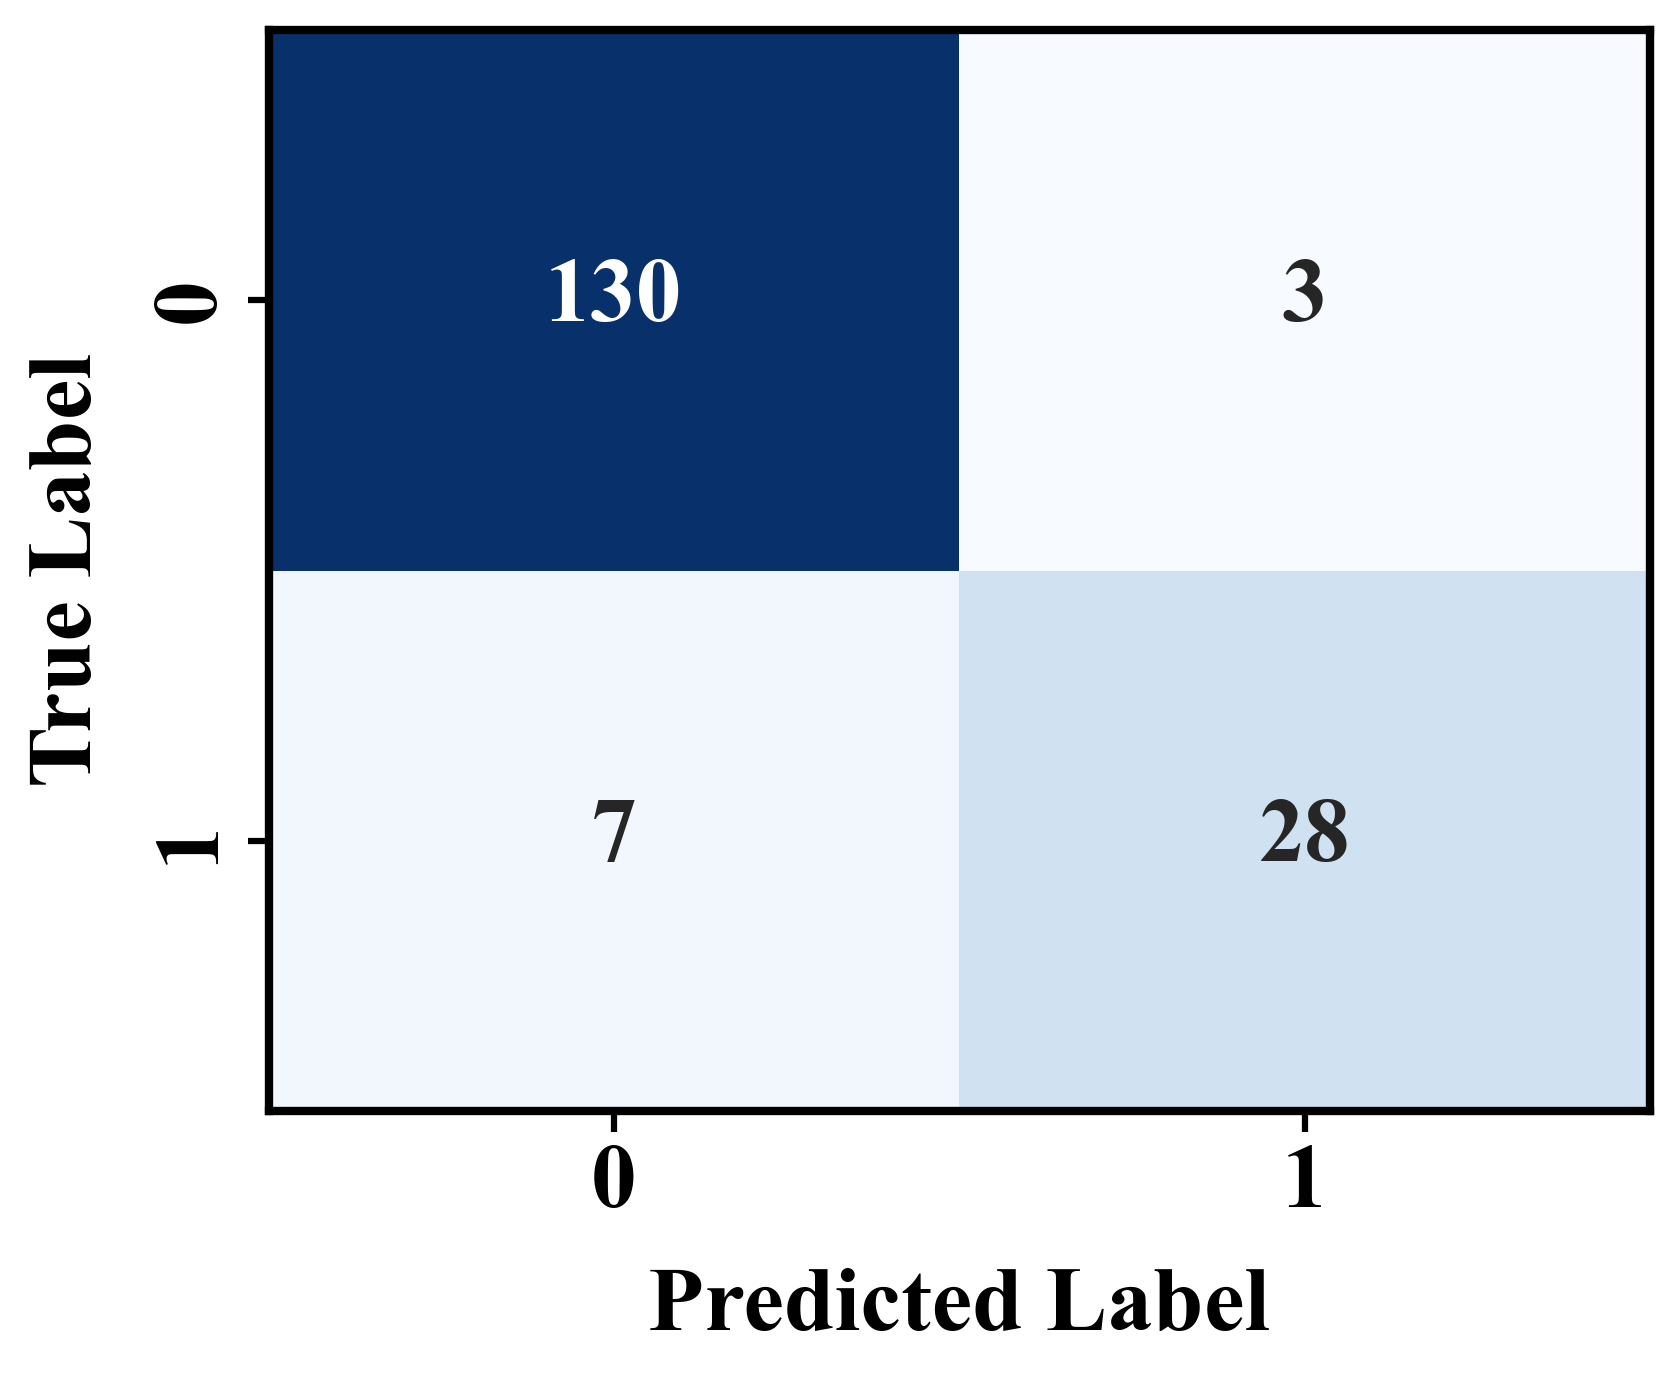

In [116]:
# 计算整体混淆矩阵
cm = confusion_matrix(all_y_val, all_y_pred_val)

# 获取分类标签
class_labels = np.unique(all_y_val)

# 创建图形
plt.figure(figsize=(6, 5), dpi=300)

# 使用 seaborn 绘制热力图
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                 xticklabels=class_labels, yticklabels=class_labels,
                 cbar=False, annot_kws={"size": 22, "weight": "bold", "fontname": "Times New Roman"})

# 设置标签字体
plt.xlabel("Predicted Label", fontsize=22, fontweight='bold', fontname='Times New Roman', labelpad=10)
plt.ylabel("True Label", fontsize=22, fontweight='bold', fontname='Times New Roman', labelpad=10)

# 设置坐标轴刻度字体
plt.xticks(fontsize=22, fontweight='bold', fontname='Times New Roman')
plt.yticks(fontsize=22, fontweight='bold', fontname='Times New Roman')
# 设置坐标轴刻刻度向外
ax.tick_params(axis='x', direction='out', length=5, width=1.5, colors='black')
ax.tick_params(axis='y', direction='out', length=5, width=1.5, colors='black')
# 设置边框线可见
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(2)
    spine.set_color('black')

#去掉网格
plt.grid(False)

# 布局优化 + 显示
plt.tight_layout()
plt.show()


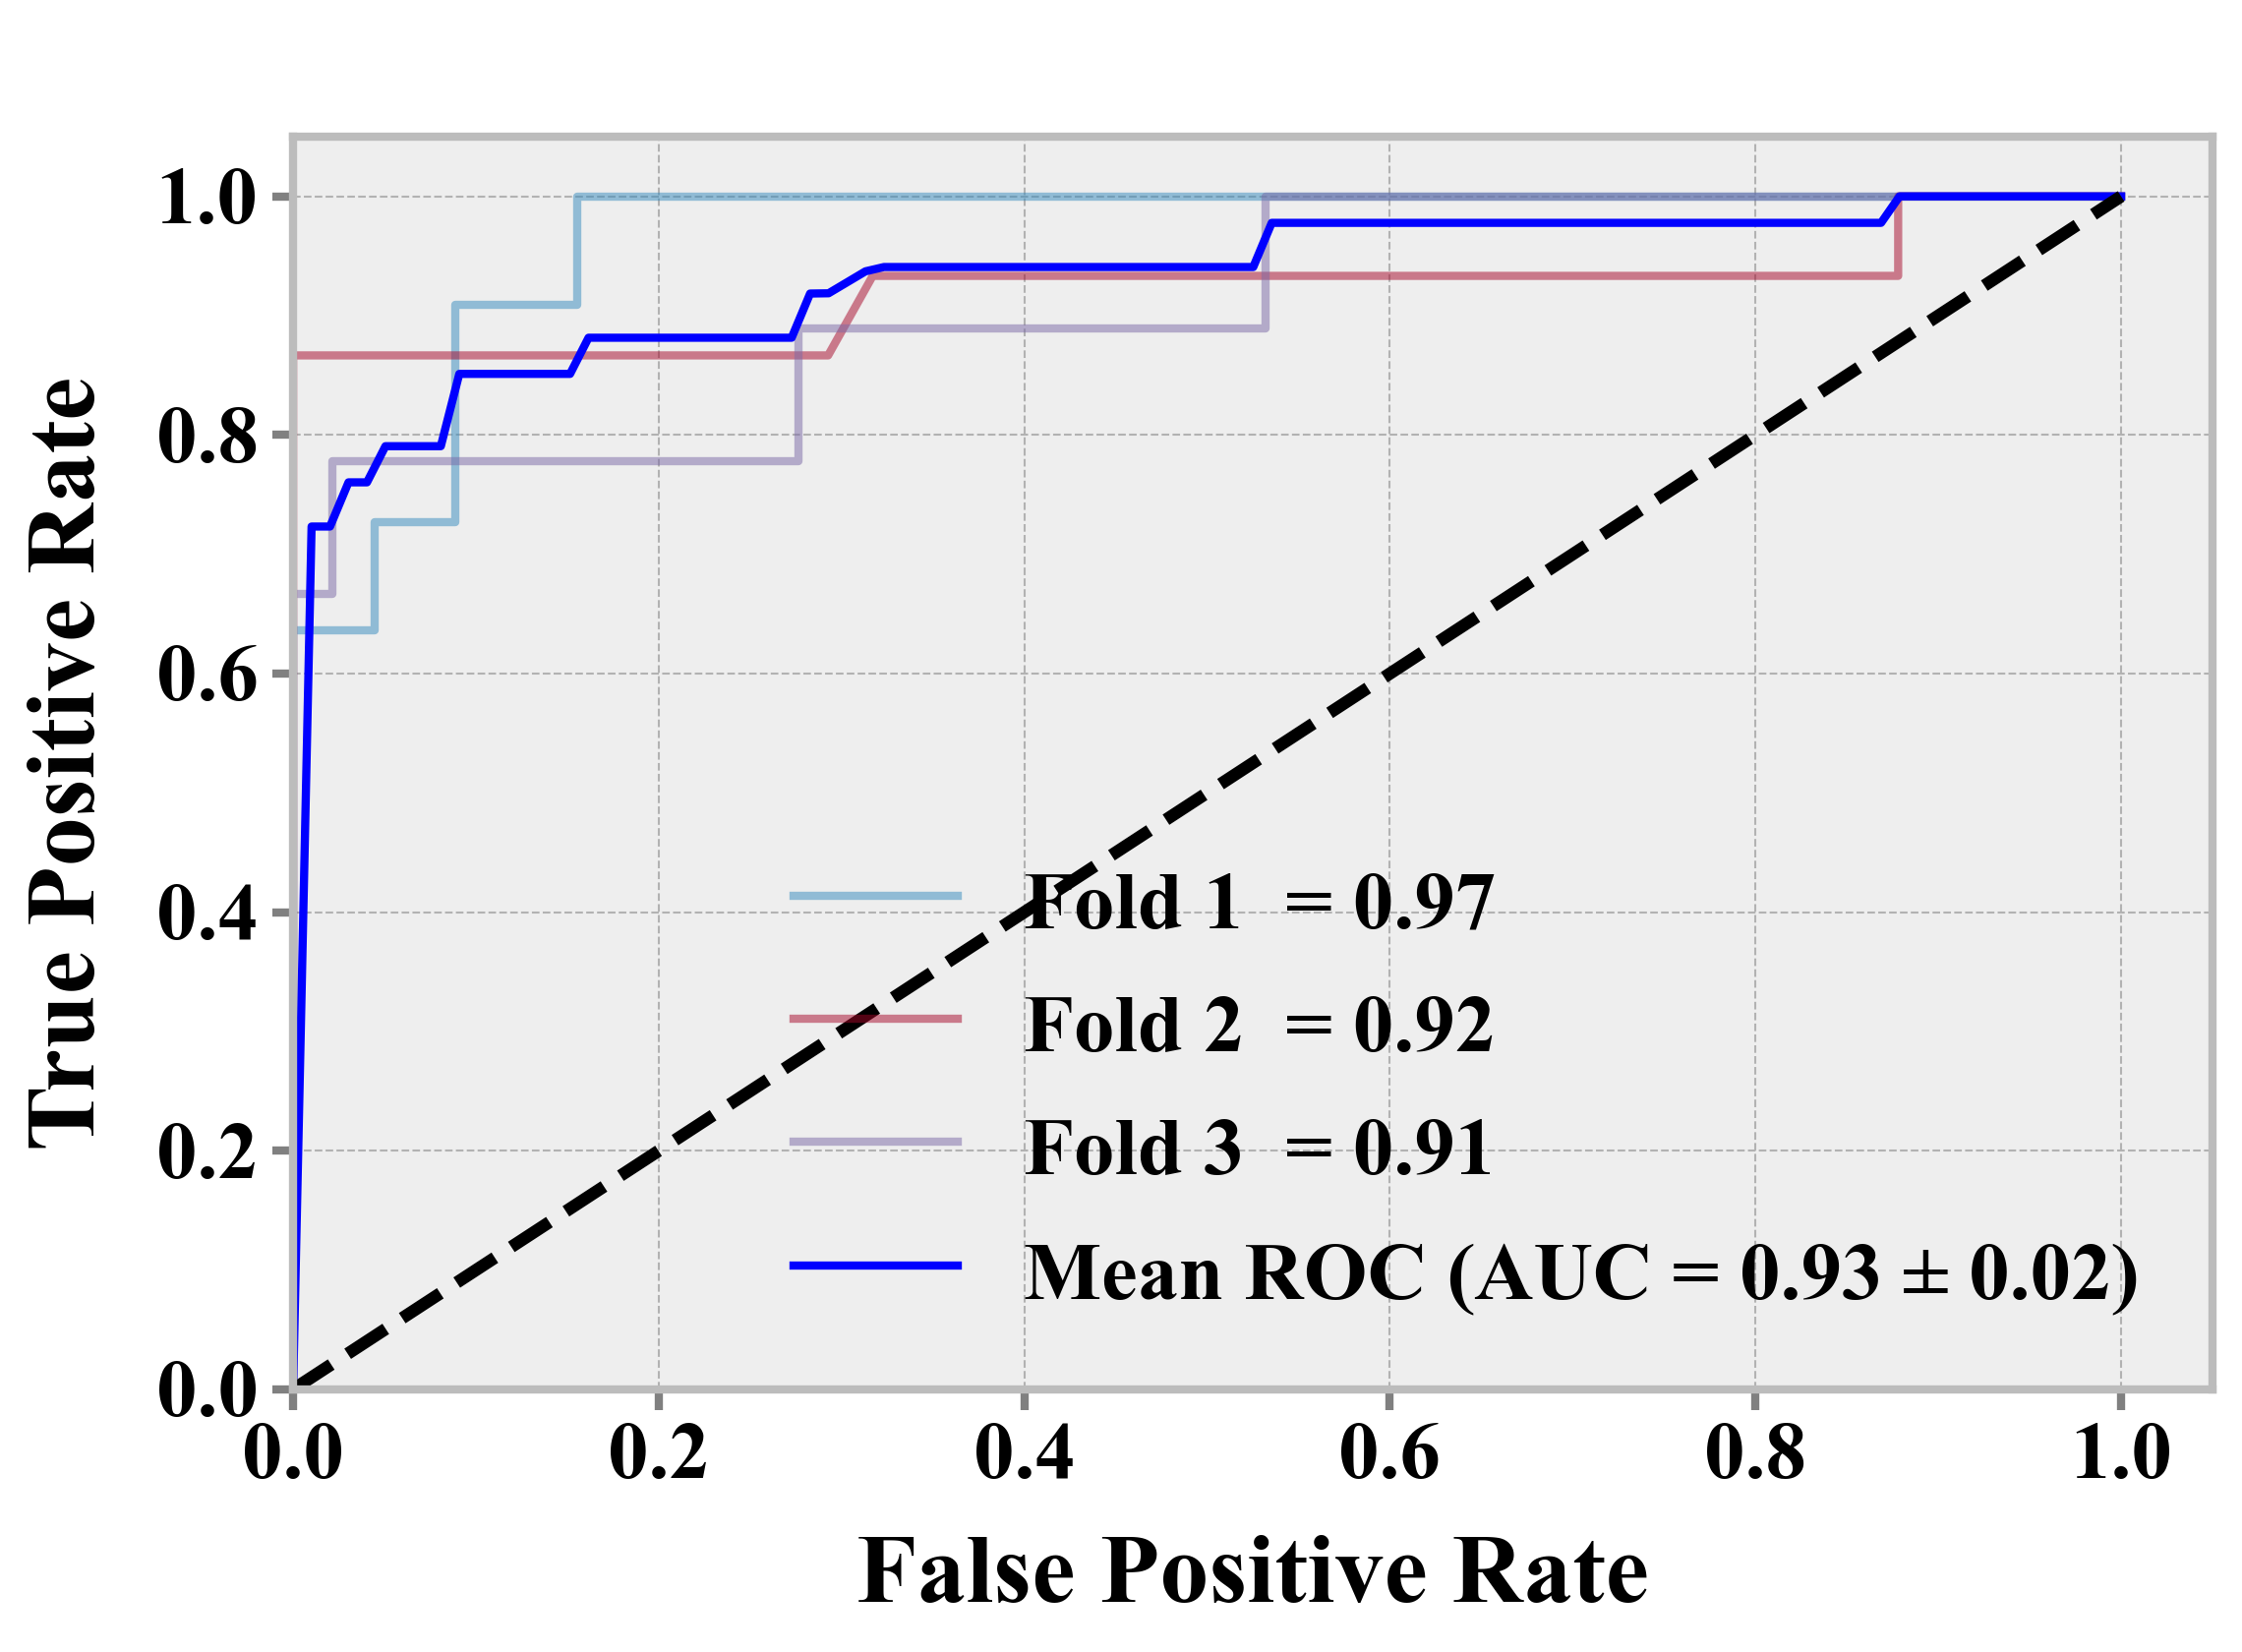

In [117]:
plt.figure(figsize=(8, 6), dpi=300)
plt.style.use('bmh')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.linewidth'] = 2
 
# 画每一折的ROC
for r in results:
    plt.plot(r['fpr'], r['tpr'], lw=2, alpha=0.5, label=f"Fold {r['fold']}  = {r['auc']:.2f}")
 
# # 画每一折的ROC
# for r in results:
#     plt.plot(r['fpr'], r['tpr'], lw=2, alpha=0.5)

# 平均ROC
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

plt.plot(mean_fpr, mean_tpr, color='blue',
         label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})',
         lw=2, alpha=1)

plt.plot([0, 1], [0, 1], 'k--', lw=3)

# 图表修饰
plt.xlim([0, 1.05])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate', fontsize=24, fontweight='bold', labelpad=10, color='black')
plt.ylabel('True Positive Rate', fontsize=24, fontweight='bold', labelpad=10, color='black')
plt.xticks(fontsize=20, fontweight='bold', color='black')
plt.yticks(fontsize=20, fontweight='bold', color='black')
plt.tick_params(axis='both', which='both', direction='out', length=5, width=2, color='gray', bottom=True, top=False, left=True, right=False)

plt.title(' ')
plt.legend(loc='lower right',  frameon=False, handlelength=2, handleheight=1, prop={'size': 20, 'weight': 'bold', 'family': 'Times New Roman'})

plt.grid(True)
plt.tight_layout()
plt.show()

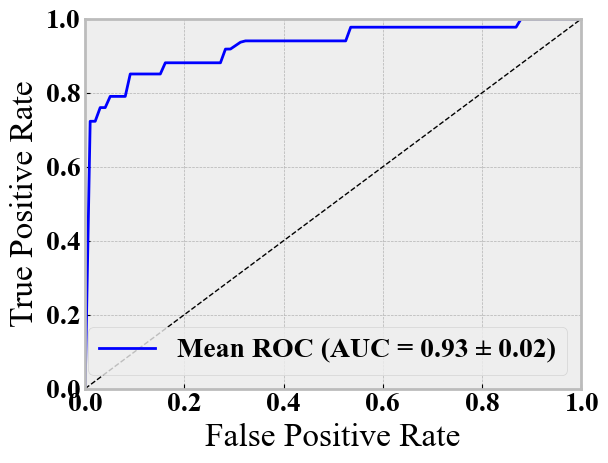

In [118]:
# 计算平均 ROC 曲线
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
# 绘制平均 ROC 曲线
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})',
         lw=2, alpha=1)

# 对角线
plt.plot([0, 1], [0, 1], 'k--', lw=1)

# 美化图表
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Mean ROC Curve (5-Fold CV)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [119]:
import shap
# 创建一个SHAP解释器
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X, check_additivity=False)
shap_values

array([[-0.13589392, -0.4084842 ,  0.60800202, ..., -0.01823333,
        -0.46820883, -3.05048324],
       [-0.03986777, -0.24807408, -0.49377633, ..., -0.01635667,
        -0.41496385, -2.78346259],
       [-0.03986777, -0.24807408, -0.49377633, ..., -0.01635667,
        -0.41496385, -2.78346259],
       ...,
       [-0.04249256, -0.13164727, -1.34850313, ..., -0.01198513,
        -0.28311475, -1.77862242],
       [-0.0359228 , -0.13164727, -1.36163644, ..., -0.01458133,
        -0.2809079 , -2.80268325],
       [-0.0359228 , -0.13164727, -1.37089137, ..., -0.01458133,
        -0.2809079 , -2.82274433]])

In [120]:
import shap
import os
import matplotlib.pyplot as plt

# 设置字体和样式
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.size'] = 20
plt.style.use('bmh')

# 创建主图
fig, ax1 = plt.subplots(figsize=(10, 8), dpi=1200)

shap.summary_plot(shap_values, X, feature_names=X.columns,
    plot_type="dot", show=False, color_bar=False, max_display=24)

plt.gca().set_position([0.2, 0.2, 0.65, 0.65])  # 调整位置为主图 ax1
ax1 = plt.gca()

# 顶部条形图（bar plot）
ax2 = ax1.twiny()
shap.summary_plot(
    shap_values, X, feature_names=X.columns,
    plot_type="bar", show=False, max_display=24
)
plt.gca().set_position([0.2, 0.2, 0.65, 0.65])  # 确保对齐

# 添加灰色参考线
ax2.axhline(y=24, color='gray', linestyle='-', linewidth=2)
# 设置透明度
for bar in ax2.patches:
    bar.set_alpha(0.2)
# 坐标轴标签设置,新罗马字体
ax1.set_xlabel('Shapley Value Contribution', fontsize=20, labelpad=10, weight='bold', fontname='Times New Roman')
ax1.set_ylabel('Features', fontsize=20, labelpad=10, weight='bold', fontname='Times New Roman')

ax2.set_xlabel('Mean (|Shapley Value|)', fontsize=20, labelpad=10, weight='bold', fontname='Times New Roman')
ax2.xaxis.set_label_position('top')
ax2.xaxis.tick_top()

# 设置三个坐标轴的刻度字体大小和粗细
for label in ax1.get_xticklabels() + ax1.get_yticklabels():
    label.set_fontsize(18)
    label.set_fontweight('bold')
    label.set_fontname('Times New Roman')

for label in ax2.get_xticklabels():
    label.set_fontsize(18)
    label.set_fontweight('bold')
    label.set_fontname('Times New Roman')

# 调整排版，保存并展示
plt.tight_layout()
plt.show()